# module load

In [9]:
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import pandas as pd


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# data load

In [98]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [12]:
train.shape

(21189, 16)

In [13]:
test.shape

(21189, 16)

In [17]:
train.dtypes.index

Index(['UNC_YEAR', 'HSCD', 'COUNTRYCD', 'COUNTRYNM', 'TRADE_COUNTRYCD',
       'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST', 'NY_GDP_MKTP_CD',
       'NY_GDP_MKTP_CD_1Y', 'SP_POP_TOTL', 'PA_NUS_FCRF',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'KR_TRADE_HSCD_COUNTRYCD'],
      dtype='object')

In [99]:
# 변수 특징 확인 Good technique!!!
cat_columns = [c for c, t in zip(train.dtypes.index, train.dtypes) if t == 'O'] 
num_columns = [c for c in train.dtypes.index if c not in cat_columns]

In [23]:
quantitative = cat_columns
qualitative = num_columns

In [22]:
quantitative

['COUNTRYNM']

In [24]:
qualitative

['UNC_YEAR',
 'HSCD',
 'COUNTRYCD',
 'TRADE_COUNTRYCD',
 'TRADE_HSCD',
 'TARIFF_AVG',
 'SNDIST',
 'NY_GDP_MKTP_CD',
 'NY_GDP_MKTP_CD_1Y',
 'SP_POP_TOTL',
 'PA_NUS_FCRF',
 'IC_BUS_EASE_DFRN_DB',
 'KMDIST',
 'TRADE_HSCD_COUNTRYCD',
 'KR_TRADE_HSCD_COUNTRYCD']

## Data describe

UNC_YEAR	기준연도	YYYY

HSCD	HS Code (품목코드)	6자리 숫자코드

COUNTRYCD	ISO 국가코드	숫자코드

COUNTRYNM	영문 국가명	Character

TRADE_COUNTRYCD	해당 연도 해당 국가의 전체 품목 수입금액	US$

TRADE_HSCD	해당 연도 해당 품목의 전세계 총 수입금액	US$

TARIFF_AVG	해당 국가에서 해당 품목에 적용되는 평균 관세율	%

SNDIST	해당 국가와 수입 국가 간 평균 거리	km

NY_GDP_MKTP_CD	GDP	US$

NY_GDP_MKTP_CD_1Y	이전년도 GDP	US$

SP_POP_TOTL	인구 (연중 추정치)	명

PA_NUS_FCRF	공식 환율 (미국 달러에 대한 현지 통화 단위, 월평균을 기준으로 한 연평균)	US$

IC_BUS_EASE_DFRN_DB	비즈니스 용이성 점수	점수 (0~100)

KMDIST	해당 국가와 한국과의 거리	km

TRADE_HSCD_COUNTRYCD	해당 연도 해당 국가의 해당 품목 수입금액	US$

KR_TRADE_HSCD_COUNTRYCD	내년 해당 국가가 해당 품목을 한국으로부터 수입한 금액	US$

## missing value viz

In [ ]:
# missing value handling
train = train.fillna(method='ffill')

<AxesSubplot:>

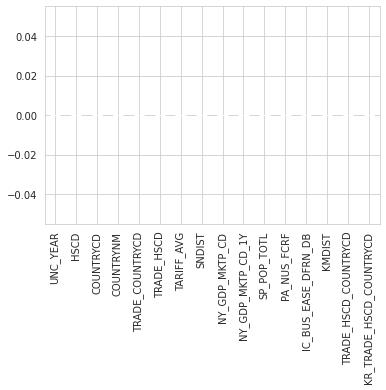

In [113]:
sns.set_style('whitegrid')
missing = train.isnull().sum()
#missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

we need to the missing value replacement (PA_NUS_FCRF) , i will that values replace that each countrys' mean()

In [36]:
train.columns

Index(['UNC_YEAR', 'HSCD', 'COUNTRYCD', 'COUNTRYNM', 'TRADE_COUNTRYCD',
       'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST', 'NY_GDP_MKTP_CD',
       'NY_GDP_MKTP_CD_1Y', 'SP_POP_TOTL', 'PA_NUS_FCRF',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'KR_TRADE_HSCD_COUNTRYCD'],
      dtype='object')

In [52]:
quantitative

['COUNTRYNM']

In [63]:
qualitative

['UNC_YEAR',
 'HSCD',
 'COUNTRYCD',
 'TRADE_COUNTRYCD',
 'TRADE_HSCD',
 'TARIFF_AVG',
 'SNDIST',
 'NY_GDP_MKTP_CD',
 'NY_GDP_MKTP_CD_1Y',
 'SP_POP_TOTL',
 'PA_NUS_FCRF',
 'IC_BUS_EASE_DFRN_DB',
 'KMDIST',
 'TRADE_HSCD_COUNTRYCD',
 'KR_TRADE_HSCD_COUNTRYCD']

In [120]:
# PA NUS FCRF 변수에 nan 값이 있는데 그 나라의 평균값으로 결측치를 대체해줄 생각.
# next...

train.groupby('COUNTRYNM')['PA_NUS_FCRF'].mean()

COUNTRYNM
Algeria                   110.973017
Australia                   1.304758
Austria                     1.304758
Belgium                     1.304758
Brazil                      3.191389
Canada                      1.297936
Chile                     648.833793
China                       6.758755
China, Hong Kong SAR        7.793250
Czechia                    23.376333
Egypt                      17.782534
France                     23.343032
Germany                    23.343098
Guatemala                   7.347939
India                      65.121569
Indonesia               13380.833880
Iran                    33226.298150
Italy                   30999.151859
Japan                     112.166141
Kazakhstan                326.001023
Kuwait                      0.303350
Malaysia                    4.300441
Mexico                     18.926517
Mongolia                 2439.777201
Myanmar                  1360.358707
Netherlands              2381.676785
New Zealand                 

# model

## Data processing

In [122]:
train['KR_TRADE_HSCD_COUNTRYCD'] = np.log1p(train['KR_TRADE_HSCD_COUNTRYCD'])
y = train['KR_TRADE_HSCD_COUNTRYCD'].reset_index(drop=True)

## Features

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=42)

In [135]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [138]:
# 변수 특징 확인 Good technique!!!
cat_columns = [c for c, t in zip(X_train.dtypes.index, X_train.dtypes) if t == 'O'] 
num_columns = [c for c in X_train.dtypes.index if c not in cat_columns]

In [139]:
print(f'범주형 변수: \n{cat_columns}\n\n 수치형 변수: \n{num_columns}\n')

범주형 변수: 
['COUNTRYNM']

 수치형 변수: 
['UNC_YEAR', 'HSCD', 'COUNTRYCD', 'TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST', 'NY_GDP_MKTP_CD', 'NY_GDP_MKTP_CD_1Y', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 'KR_TRADE_HSCD_COUNTRYCD']



In [140]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])

X_valid[num_columns] = scaler.transform(X_valid[num_columns])
# tmp_test[num_columns]  = scaler.transform(tmp_test[num_columns])

In [144]:
cat = pd.get_dummies(X_train['COUNTRYNM'])
cat2 = pd.get_dummies(X_valid['COUNTRYNM'])

In [149]:
X_train.columns

Index(['UNC_YEAR', 'HSCD', 'COUNTRYCD', 'COUNTRYNM', 'TRADE_COUNTRYCD',
       'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST', 'NY_GDP_MKTP_CD',
       'NY_GDP_MKTP_CD_1Y', 'SP_POP_TOTL', 'PA_NUS_FCRF',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'KR_TRADE_HSCD_COUNTRYCD'],
      dtype='object')

In [157]:
X_train = pd.concat([X_train, cat],axis=1).drop(columns=['COUNTRYNM','UNC_YEAR'])
X_valid = pd.concat([X_valid, cat2],axis=1).drop(columns=['COUNTRYNM','UNC_YEAR'])

In [186]:
from sklearn.metrics import mean_squared_error

In [203]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

In [179]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [180]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [181]:
gbr = GradientBoostingRegressor(n_estimators=3000,
                                learning_rate=0.05,
                               max_depth=4,
                               max_features='sqrt',
                               min_samples_leaf=15,
                               min_samples_split=10,
                               loss='huber',
                               random_state=42)

In [182]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [183]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [184]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [194]:
from sklearn.model_selection import cross_val_score

In [195]:
scores = cross_val_score(ridge, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=10)

In [196]:
ridge_rmse_scores = np.sqrt(-scores)

In [201]:
def display_scores(scores):
    print(f'점수: {scores} \n')
    print(f'평균: {scores.mean()} \n')
    print(f'표준편차: {scores.std()} \n')

In [202]:
display_scores(ridge_rmse_scores)

점수: [7.26767085e-05 6.38929815e-05 5.21163278e-05 7.08043797e-05
 7.12123534e-05 6.21867836e-05 5.95381790e-05 7.46185416e-05
 6.50386647e-05 5.74042177e-05] 

평균: 6.49489137536528e-05 

표준편차: 6.973979028412043e-06 



In [223]:
scores = cross_val_score(lasso, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)

In [225]:
lasso_rmse_scores = np.sqrt(-scores)

In [227]:
display_scores(lasso_rmse_scores)

점수: [2.46537905e-05 2.25799963e-05 1.78220882e-05 2.46160271e-05
 2.52466841e-05 2.13188638e-05 2.05105752e-05 2.37782668e-05
 2.25383331e-05 1.97692323e-05] 

평균: 2.228338574111061e-05 

표준편차: 2.2918577489858477e-06 



Future work

- 결측치 각 나라별 mean으로 채워넣기.

- blending , stacking 적용하기 .

[solution](https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1?scriptVersionId=12846740)

